In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install mtcnn
!pip install --upgrade cython
!pip install --upgrade setuptools
!pip install nmslib
!pip install pandas
!pip install cmake
!pip install dlib
!pip install imutils
!pip install face_recognition

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-0qft_54v
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-0qft_54v
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=c40e1d8f2f59d3f00a6a92987c59bd4714fe662f020d53dab814a0cd48e3e1a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3305w3w/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 2.3MB 6.2MB/s 
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.17)
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)
     |████████████████████████████████| 13.0MB 6.5MB/s 
     |████████████████████████████████| 296kB 51.7MB/s 
     |████████████████████████████████| 100.2MB 54kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive/FaceProcessing/code/output

l2_resnet50_face_to_image.pkl	    MiniCelebA_vgg16_FacialFeatures.hnsw
l2resnet50_face_to_image.pkl	    resnet50_face_to_image.pkl
l2_resnet50_FacialFeatures.hnsw     resnet50_FacialFeatures.hnsw
l2resnet50_FacialFeatures.hnsw	    vgg16_face_to_image.pkl
MiniCelebA_vgg16_face_to_image.pkl  vgg16_FacialFeatures.hnsw


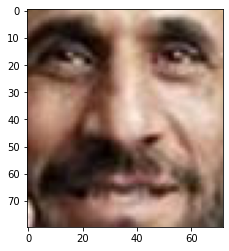

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import nmslib
import pickle

index_folder = '/content/gdrive/My Drive/FaceProcessing/code/output/'
imgs_folder = '/content/gdrive/My Drive/FaceProcessing/data/miniCelebA/'

face_path = imgs_folder + 'train/0/344_0.png'
image = plt.imread(face_path)
plt.imshow(image)

In [0]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.loadIndex(index_folder + 'MiniCelebA_vgg16_FacialFeatures.hnsw')

In [0]:
file = open(index_folder + 'MiniCelebA_vgg16_face_to_image.pkl', 'rb')
face_id_map = pickle.load(file)

In [6]:
from keras_vggface import utils
from keras import Model
from keras_vggface.vggface import VGGFace
from keras.layers import GlobalAveragePooling2D
from PIL import Image
import numpy as np

image_size = (224, 224, 3)
def get_feature_extraction_model(model_type):
    if model_type == "vgg16":
        model = VGGFace(model=model_type, include_top=False
                        , input_shape=image_size, pooling='avg')
        output = model.get_layer('conv5_3').output
        output = GlobalAveragePooling2D()(output)
        feature_model = Model(inputs=model.input, outputs=output)
    elif self.model_type == "resnet50":
        feature_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    return feature_model
    
def get_deep_feature(model_type, x):
    feature_model = get_feature_extraction_model(model_type)
    x = utils.preprocess_input(x, version=1)  # or version=2
    x = feature_model.predict(x)
    return x

Using TensorFlow backend.


In [0]:
def face_search(face_path):
  image = plt.imread(face_path)
  plt.imshow(image)
  plt.show()
  img = Image.fromarray((image * 255).astype(np.uint8))
  img = np.array(img.resize((224, 224)))
  if img.ndim == 2:
      img = np.expand_dims(img, -1)
      img = np.concatenate((img, img, img), axis=-1)

  face = img.astype(np.float64)
  face = np.expand_dims(face, axis=0)
  feature = get_deep_feature("vgg16", face)
  #print(len(feature[0]))

  ids, distances = index.knnQuery(feature[0], k=100)
  # print((ids, distances))
  fig, axs = plt.subplots(10, 10, figsize=(100,100), facecolor='w', edgecolor='k')
  axs = axs.ravel()
  # for id in ids[:10]:
  #   print(face_id_map[id][face_id_map[id].index('//'):])
  input_id = face_path.split('/')[-2]
  print('Input id: ' + str(input_id))
  true_pos = 0
  for i, id in enumerate(ids):
    #print(face_id_map[id].split('/')[1])
    if int(input_id) == int(face_id_map[id].split('/')[1]):
      true_pos += 1
    img = plt.imread(face_id_map[id][face_id_map[id].index('//'):])
    axs[i].imshow(img)
    axs[i].set_title("{:.4f}".format(distances[i]), fontsize=70)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])
  
  total_results = len(ids)
  accuracy = true_pos / total_results
  print('Accuracy : ' + str(accuracy))

In [9]:
face_path = imgs_folder + 'train/0/344_0.png'
face_search(face_path)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
face_path = imgs_folder + 'train/1/0_0.png'
face_search(face_path)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
face_path = imgs_folder + 'test/4/340_8.png'
face_search(face_path)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
face_path = imgs_folder + 'train/7/291_0.png'
face_search(face_path)

Output hidden; open in https://colab.research.google.com to view.